In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization

print(tf.__version__) # 2.6.0

2.6.0


In [2]:
from pathlib import Path

# Obter todas as fotos de caule
path = Path( 'fotos/by_section' )
caule = list( path.glob( 'caule/*.jpg' ) )
img_count = len( caule )

In [3]:
# Vou usar o seguinte esquema:
# 80% das imagens serão usadas para treinar a ML
# 20% para validar a precisão
batch_size = 32
img_width = 100
img_height = 100

In [4]:
# Criar dataset para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 396 files belonging to 4 classes.
Using 317 files for training.


2021-11-01 23:10:08.032799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-01 23:10:08.077887: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# Criar dataset para validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 396 files belonging to 4 classes.
Using 79 files for validation.


In [6]:
class_names = train_ds.class_names
print( class_names )

['caule', 'flor', 'folha', 'fruto']


In [7]:
def fire(x, squeeze, expand):
    y = Conv2D(squeeze, 1, padding='same', activation='relu')(x)
    y = BatchNormalization(momentum=0.9)(y)

    y1 = Conv2D(expand//2, 1, padding='same', activation='relu')(y)
    y1 = BatchNormalization(momentum=0.9)(y1)

    y3 = Conv2D(expand//2, 3, padding='same', activation='relu')(y)
    y3 = BatchNormalization(momentum=0.9)(y3)

    return concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

In [8]:
# Criação do modelo
num_classes = 4

x = Input(shape=(100, 100, 3))

y = Conv2D(32, 3, padding='same', activation='relu')(x)
y = BatchNormalization(momentum=0.9)(y)
y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = GlobalAveragePooling2D()(y)
y = Dense(4, activation='softmax')(y)

model = Model(x, y)

In [9]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Exibir resumo do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# Treinar o modelo
epochs = 64
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/64


2021-11-01 23:10:14.614758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10/10 [==============================] - 39s 3s/step - loss: 1.2600 - accuracy: 0.4006 - val_loss: 1.3613 - val_accuracy: 0.3291
Epoch 2/64
10/10 [==============================] - 31s 3s/step - loss: 1.0250 - accuracy: 0.5931 - val_loss: 1.2523 - val_accuracy: 0.4304
Epoch 3/64
10/10 [==============================] - 29s 3s/step - loss: 0.9135 - accuracy: 0.6562 - val_loss: 1.0279 - val_accuracy: 0.5823
Epoch 4/64
10/10 [==============================] - 29s 3s/step - loss: 0.8716 - accuracy: 0.6625 - val_loss: 1.0786 - val_accuracy: 0.4684
Epoch 5/64
10/10 [==============================] - 29s 3s/step - loss: 0.8241 - accuracy: 0.6625 - val_loss: 1.0044 - val_accuracy: 0.5190
Epoch 6/64
10/10 [==============================] - 29s 3s/step - loss: 0.7833 - accuracy: 0.7098 - val_loss: 0.9815 - val_accuracy: 0.5823
Epoch 7/64
10/10 [==============================] - 30s 3s/step - loss: 0.7541 - accuracy: 0.7161 - val_loss: 0.8789 - val_accuracy: 0.6456
Epoch 8/64
10/10 [=============

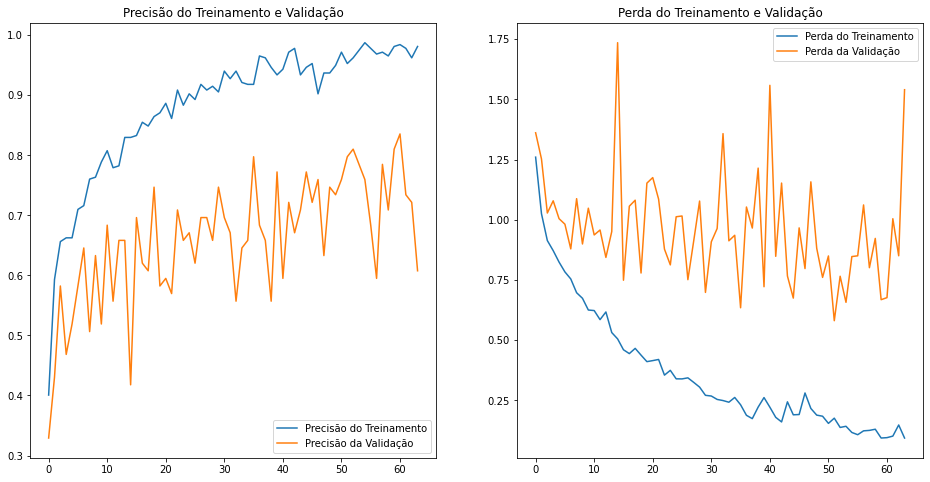

In [11]:
# Estatisticas sobre o treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotar gráficos de precisão e perda
plt.figure( figsize=(16, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão do Treinamento')
plt.plot(epochs_range, val_acc, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.title('Precisão do Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda do Treinamento')
plt.plot(epochs_range, val_loss, label='Perda da Validação')
plt.legend(loc='upper right')
plt.title('Perda do Treinamento e Validação')
plt.show()

In [12]:
# Testar a ML
# aqui estou usando 4 imagens, uma para cada classe, removidas da pasta 'fotos'
# para verificar se a ML realmente funciona
test_path = Path( 'fotos/testes' )
test_images = list( test_path.glob( '*.jpg' ) )
for image in test_images:
    img = tf.keras.utils.load_img(
        image, target_size=(img_width, img_height)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax( predictions[0] )
    print( f"Essa imagem provavelmente pertence à classe '{ class_names[ np.argmax(score) ] }' com uma confiança de {(100 * np.max(score)):.2f}%" )

Essa imagem provavelmente pertence à classe 'caule' com uma confiança de 34.15%
Essa imagem provavelmente pertence à classe 'flor' com uma confiança de 47.54%
Essa imagem provavelmente pertence à classe 'folha' com uma confiança de 47.54%
Essa imagem provavelmente pertence à classe 'fruto' com uma confiança de 45.77%


In [13]:
# Exportar a ML
from pathlib import Path
ROOT_DIR = Path('..').resolve()
MODELS_PATH = Path( ROOT_DIR, 'models' )
MODEL_PATH = Path( MODELS_PATH, 'section.h5' )

model.save( MODEL_PATH )